<a href="https://colab.research.google.com/github/IFuentesSR/Reservoir_EMS/blob/main/Main_reservoir_volume_uncertainty_EMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading GEE, authenticating and importing packages

In [1]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=iToZzXtaELM_zacj5nHd2nb76S8zoHMVTEVDgdCPBHw&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g5to4NxdhwVUW6RQ2936aKeSKA0KYcG2iwK5BXz0MQlumH2YwLPQcw

Successfully saved authorization token.


In [2]:
import folium
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from scipy import stats, fftpack, signal
from scipy.interpolate import interp1d
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

## installing and importing EMCEE

In [18]:
!pip install emcee
!pip install corner
import emcee
import corner
from scipy.interpolate import interp1d

     |████████████████████████████████| 51kB 3.9MB/s 


## Sentinel preprocessing functions

In [28]:
def getS2_CLOUD_PROBABILITY(geo):
    '''it joins Sentinel 2 and Sentinel 2 Cloud probability ImageCollections. 
    inputs:
    geo:geometry;
    output:ImageCollection'''
    innerJoined = ee.Join.inner().apply(primary=ee.ImageCollection("COPERNICUS/S2_SR").filterBounds(geo),
                                        secondary=ee.ImageCollection("COPERNICUS/S2_CLOUD_PROBABILITY").filterBounds(geo),
                                        condition=ee.Filter.equals(leftField='system:index',
                                                                   rightField='system:index'))
    def mergeImageBands(joinResult):
        return ee.Image(joinResult.get('primary')).addBands(joinResult.get('secondary'))

    newCollection = innerJoined.map(mergeImageBands)
    return ee.ImageCollection(newCollection)


def maskClouds(_img):
    '''it masks pixels with a cloud probability > 30%: 
    input:raster; output:raster'''
    cloudProbabilityThreshold = 30
    cloudMask = _img.select('probability').lt(cloudProbabilityThreshold)
    return _img.updateMask(cloudMask)


def mask_empty(geo):
    '''it sets a ratio of unmasked pixels to filter images: 
    inputs:
    img:raster; geo:geometry
    output:raster'''
    def inner(img):
        area = geo.area(1)
        area_img = ee.Number(img.select('B1').gt(-999).multiply(ee.Image.pixelArea()).reduceRegion('sum', geo, 10, maxPixels=1e13).values().get(0))
        img = img.set('area', area_img.divide(area))
        return img
    return inner


def CloudMaskS2(image):
    '''it masks shadows from sentinel 2 raster: 
    input:raster; output:raster'''
    prop = image.propertyNames()
    QA = image.select('SCL')
    shadows = 3
    mask = QA.neq(shadows)
    return image.updateMask(mask).multiply(0.0001).copyProperties(image, prop)
 

def getProfile(dem, line, pointCount, reducer, scale):
    '''it creates a FeatureCollection with elevations and distances from line
    inputs:
    line:geometry; scale:integer; dem:raster; pointCount:integer; reducer:reducer 
    output:FeatureCollection'''
    length = line.length()
    step = length.divide(pointCount)
    distances = ee.List.sequence(0, length, step)
    segments = line.cutLines(distances).geometries()
    def inner(i):
        i = ee.List(i)
        return ee.Feature(ee.Geometry(i.get(0)).centroid(), {'distance': i.get(1)})
    features = segments.zip(distances).map(inner)
    features = ee.FeatureCollection(features)
    features = dem.reduceRegions(features, reducer, scale)
    return features


def WI(img):
    '''it applies Fisher et al. (2015) algorithm for water detection: 
    input:raster; output:raster'''
    return img.expression('1.7204 + 171 * Green + 3 * Red - 70 * NIR - 45 * SWIR1 - 71 * SWIR2',
    {'Green':img.select('B3'),'Red':img.select('B4'), 
    'NIR':img.select('B8'),'SWIR1':img.select('B11'),
    'SWIR2':img.select('B12')}).rename('WI').copyProperties(img, ['system:time_start'])


def waterFunc(img):
    '''it creates a mask for water: input:raster; output:raster'''
    return img.gt(0).copyProperties(img, ['system:time_start'])


def set_area(fea):
    '''it sets area to feature: input:feature; output:feature'''
    return fea.set('area', fea.area(1))

## Vectorial processing functions

In [29]:
def multipolProc(i):
    '''it drops polygons within multipolygons with few vertices:
    input:feature; output:feature'''
    def inner(l):
        return ee.Algorithms.If(ee.List(l).size().gt(0),
                                ee.List(l),
                                None)
    
    def wrap(l):
        return ee.Algorithms.If(ee.List(l).size().lt(100),
                                None,
                                ee.List(l))
    
    def inner2(i):
        return ee.List(i).map(wrap).removeAll([None])
    
    def inner3(l):
        return ee.Algorithms.If(ee.List(l).size().eq(0), 
                                ee.Feature(None, {'drop':1}),
                                ee.Feature(ee.Geometry.MultiPolygon(l), {'drop': 0}))


    coords = i.geometry().coordinates()
    coords = coords.map(inner).removeAll([None])
    coords = coords.map(inner2)
    coords = coords.map(inner3)
    return coords


def polygonProc(i):
    '''it drops polygons with few vertices:
    input:feature; output:feature'''
    def inner(l):
        return ee.Algorithms.If(ee.List(l).size().gt(50),
                                l,
                                None)
    coords = i.geometry().coordinates()

    coords = coords.map(inner).removeAll([None])
    coords = ee.Algorithms.If(coords.size().eq(0),
                              ee.Feature(None, {'drop':1}),
                              ee.Feature(ee.Geometry.Polygon(coords), {'drop':0}))
    return coords


def geoColl(i):
    '''it drops polygons in geoCollections with few vertices.
    input:feature; output:geometry'''
    def inner(l):
        return ee.Algorithms.If(ee.List(ee.Geometry(l).coordinates().get(0)).size().lt(100),
                                None,
                                ee.List(ee.Geometry(l).coordinates().get(0)))
    coords = i.geometry().geometries()
    coords = coords.map(inner)
    coords = coords.removeAll([None])
    return ee.Geometry.Polygon(coords)


def cleanPolys(current, previous):
    '''it cleans features with few vertices based on previous funtions.
    input:list or featurecollection; output:list'''
    condition =  ee.Algorithms.If(ee.Feature(current).geometry().type().compareTo('Polygon').Not(),
                                  polygonProc(ee.Feature(current)),
                                  ee.Algorithms.If(ee.Feature(current).geometry().type().compareTo('GeometryCollection').Not(),
                                                   geoColl(ee.Feature(current)),
                                                   ee.List(multipolProc(ee.Feature(current)))))
    return ee.List(previous).add(condition)


def get_poly(level, dam, dem):
    '''gets cleaned water polygons based on the water level within reservoir.
    inputs:
    level:float/integer; dam:geometry; dem:raster; 
    output:FeatureCollection'''
    level = ee.Number(level)
    ele = dem.clip(dam).updateMask(dem.clip(dam).lte(level))
    ele = ele.lte(level).addBands(ele).reduceToVectors('mean', dam, 1, maxPixels=1e13)
    ele = ele.iterate(cleanPolys, ee.List([]))
    ele = ee.FeatureCollection(ee.List(ele).flatten()).filter(ee.Filter.eq('drop', 0))
    return ele


def get_vols(dam, dem, MaxPoly):
    '''gets volume, area and level from elevation for a reservoir.
    inputs:
    MaxPoly:Feature; dam:geometry; dem:raster; 
    output:Feature'''
    def inner(level):
        level = ee.Number(level)
        ele = dem.clip(dam).updateMask(dem.clip(dam).lte(level))
        area = ele.lte(level).multiply(ee.Image.pixelArea()).reduceRegion('sum', MaxPoly.geometry(), 1, maxPixels=1e13).values().get(0)
        vol = ele.lte(level).multiply(ee.Image(level).subtract(dem)).multiply(ee.Image.pixelArea()).reduceRegion('sum', MaxPoly.geometry(), 1, maxPixels=1e13).values().get(0)
        return ee.Feature(None, {'level': level, 'volume': ee.Number(vol), 'area': ee.Number(area)})
    return inner


def get_inputs(img, MaxPoly, dam, dem, projection):
    '''retrieves values of water index and partial flodded areas from elevation.
    inputs:
    img:raster; dam:geometry; dem:raster; projection:projection; MaxPoly:Feature, 
    output:Feature'''
    def wrap(lev):
        img2 = ee.Image(WI(img)).rename('wi')
        poly = ee.FeatureCollection(get_poly(lev, dam, dem))
        water = dem.clip(poly).gt(0)
        both = water.reduceResolution(reducer=ee.Reducer.count(), maxPixels=1024).reproject(crs=projection)
        both = ee.Image(0).where(both.gt(0), both).rename('b1')
        both = both.updateMask(img2.gte(-999))
        both1 = both.addBands(img2)
        values = both1.sample(MaxPoly.geometry().buffer(10), 10, projection, dropNulls=False)
        wi = values.aggregate_array('wi')
        Ai = values.aggregate_array('b1')
        return ee.Feature(None, {'level': lev, 'wi':wi, 'Ai':Ai})
    return wrap

## Likelihood functions

In [30]:
def partial_slope_intercept(areas, wis):
    """retrieves tuple of linear regression coefficients.

    Parameters
    ----------
    areas : np.array
        array containing pixel flooded areas.
    wis : np.array
        array containing water indexes.

    Returns
    -------
    slope
        slope of linear regression.
    intercept
        intercept of linear regression.
    """
    with np.errstate(invalid='ignore'):
        partial_areas = np.where((areas == 0) | (areas == 120),
                                np.nan,
                                areas)
        partial_wis = np.where((areas == 0) | (areas == 120),
                            np.nan,
                            wis)
    x = partial_areas[~np.isnan(partial_areas) & ~np.isnan(partial_wis)]
    y = partial_wis[~np.isnan(partial_areas) & ~np.isnan(partial_wis)]
    lin = linear_model.LinearRegression()
    lin.fit(x.reshape(-1,1), y.reshape(-1,1))
    slope, intercept = lin.coef_[0][0], lin.intercept_[0]
    return slope, intercept


def partial_predicted(areas, wis):
    """retrieves array of partial predicted water indexes.

    Parameters
    ----------
    areas : np.array
        array containing pixel flooded areas.
    wis : np.array
        array containing water indexes.

    Returns
    -------
    predicted
        array of predicted water indexes for partial pixels
    """
    with np.errstate(invalid='ignore'):
        partial_areas = np.where((areas == 0) | (areas == 120),
                                 np.nan,
                                 areas)
    slope, intercept = partial_slope_intercept(areas, wis)
    predicted = partial_areas * slope + intercept
    return predicted


def partial_residuals(areas, wis):
    """retrieves array of partial residuals for water indexes.

    Parameters
    ----------
    areas : np.array
        array containing pixel flooded areas.
    wis : np.array
        array containing water indexes.

    Returns
    -------
    predicted
        array of residuals for water indexes for partial pixels
    """
    with np.errstate(invalid='ignore'):
        partial_wis = np.where((areas == 0) | (areas == 120),
                            np.nan,
                            wis)
    predicted = partial_predicted(areas, wis)
    residuals = partial_wis - predicted
    return residuals


def full_params(wis):
    """retrieves mean and standard deviation of fully flooded pixels (wi > 10).

    Parameters
    ----------
    wis : np.array
        array containing water indexes.

    Returns
    -------
    mean_full
        mean of fully flooded pixels.
    std_full
        standard deviation of fully flooded pixels.
    """
    with np.errstate(invalid='ignore'):
        wis = np.where((wis < 0),
                       np.nan,
                       wis)
    mean_full, std_full = np.nanmean(wis), np.std(wis[~np.isnan(wis)])
    return mean_full, std_full


def empty_params(wis):
    """retrieves mean and standard deviation of fully empty pixels (wi < -10).

    Parameters
    ----------
    wis : np.array
        array containing water indexes.

    Returns
    -------
    mean_empty
        mean of empty flooded pixels.
    std_empty
        standard deviation of empty flooded pixels.
    """
    with np.errstate(invalid='ignore'):
        wis = np.where((wis > 0),
                       np.nan,
                       wis)
    mean_empty, std_empty = np.nanmean(wis), np.std(wis[~np.isnan(wis)])
    return mean_empty, std_empty


def get_logLike(areas, wis):
    """retrieves log_likelihood.

    Parameters
    ----------
    areas : np.array
        array containing pixel flooded areas.
    wis : np.array
        array containing water indexes.

    Returns
    -------
    log_like
        log lokelihood for forward model and full flooded and empty pixels.

    """
    with np.errstate(invalid='ignore'):
        partial_wis = np.where((areas == 0) | (areas == 120),
                            np.nan,
                            wis)
    sigma = np.std(partial_wis[~np.isnan(partial_wis)])
    part_res = partial_residuals(areas, wis)
    loglike_par = -0.5 * np.nansum(part_res**2/sigma**2) \
    + -0.5 * partial_wis[~np.isnan(partial_wis)].shape[0] * np.log(2 * np.pi * sigma**2)

    mean_full, sd_full = full_params(wis)
    wis_full = wis[areas == 120]
    loglike_full = -0.5 * np.nansum((wis_full-np.ones(wis_full.shape)*mean_full)**2/sd_full**2) \
    + -0.5 * wis_full.shape[0] * np.log(2 * np.pi * sd_full**2)

    mean_empty, sd_empty = empty_params(wis)
    wis_empty = wis[areas == 0]
    loglike_empty = -0.5 * np.nansum((wis_empty-np.ones(wis_empty.shape)*mean_empty)**2/sd_empty**2) \
    + -0.5 * wis_empty.shape[0] * np.log(2 * np.pi * sd_empty**2)
    
    log_like = loglike_par + loglike_full + loglike_empty
    return log_like


def get_logLike2(areas, wis):
    """retrieves log_likelihood applying sigma parameterization.

    Parameters
    ----------
    areas : np.array
        array containing pixel flooded areas.
    wis : np.array
        array containing water indexes.

    Returns
    -------
    log_like
        log lokelihood for forward model and full flooded and empty pixels.

    """
    areas = areas[~np.isnan(wis)]
    wi = wis[~np.isnan(wis)]
    A0, Afsc = 120.0, 0.05
    w_empty = np.exp(-(areas/A0)/Afsc)
    w_full = np.exp((areas/A0 - 1)/Afsc)
    w_part = 1 - w_empty - w_full
    with np.errstate(invalid='ignore'):
        partial_wis = np.where((areas == 0) | (areas == 120),
                            np.nan,
                            wi)
    slope, intercept = partial_slope_intercept(areas, wi)
    sigma = np.std(partial_wis[~np.isnan(partial_wis)])
    mu = intercept + slope*areas
    mean_full, sd_full = full_params(wi)
    mean_empty, sd_empty = empty_params(wi)

    mu += w_empty*(mean_empty - intercept)
    mu += w_full*(mean_full - intercept - slope*A0)
    var = w_part*sigma**2 + w_empty*sd_empty**2 + w_full*sd_full**2
    logLike = -0.5*np.sum((wi-mu)**2/var + np.log(2*np.pi*var))
    return logLike


def get_residuals(areas, wis):
    """retrieves residuals of linear relationship and parameterization.

    Parameters
    ----------
    areas : np.array
        array containing pixel flooded areas.
    wis : np.array
        array containing water indexes.

    Returns
    -------
    residuals
        residuals for forward model and full flooded and empty pixels.

    """
    areas = areas[~np.isnan(wis)]
    wi = wis[~np.isnan(wis)]
    A0, Afsc = 120.0, 0.05
    w_empty = np.exp(-(areas/A0)/Afsc)
    w_full = np.exp((areas/A0 - 1)/Afsc)
    w_part = 1 - w_empty - w_full
    with np.errstate(invalid='ignore'):
        partial_wis = np.where((areas == 0) | (areas == 120),
                            np.nan,
                            wi)
    slope, intercept = partial_slope_intercept(areas, wi)
    sigma = np.std(partial_wis[~np.isnan(partial_wis)])
    mu = intercept + slope*areas
    mean_full, sd_full = full_params(wi)
    mean_empty, sd_empty = empty_params(wi)

    mu += w_empty*(mean_empty - intercept)
    mu += w_full*(mean_full - intercept - slope*A0)
    residuals = wi - mu
    return residuals

## Conversion functions (GEE to np arrays)


In [31]:
def get_areas(MaxPoly, dam, dem, projection):
    """Creates partial flooded areas given the elevation.

    Parameters
    ----------
    MaxPoly : ee.Feature
        reservoir border polygon.
    dam : ee.Geometry
        reservoir polygon.
    dem : ee.Image
        digital elevation model.
    projection : ee.Projection
        projection to aggregate the dem data

    Returns
    -------
    regresor
        partial flooded areas raster."""
    def wrap(lev):
        poly = ee.FeatureCollection(get_poly(lev, dam, dem))
        water = dem.clip(poly).gt(0)
        both = water.reduceResolution(reducer=ee.Reducer.count(), maxPixels=1024).reproject(crs=projection)
        both = ee.Image(0).where(both.gt(0), both).rename('b1')
        regresor = both.clip(MaxPoly.geometry().buffer(10))
        return regresor.set('elevation', lev)
    return wrap


def get_names(c, p):
    """Creates a list of names for levels from iteration.

    Parameters
    ----------
    c : number
        current element.
    p : ee.List
        previous element.

    Returns
    -------
    list of strings with levels."""
    return ee.List(p).add(ee.String('L_').cat(ee.Number(c).format().replace('\\.', ',')))


def get_x(MaxPoly, dam, dem, projection, elevations):
    """Creates Multiband image from partial areas flooded.

    Parameters
    ----------
    MaxPoly : ee.Feature
        reservoir border polygon.
    dam : ee.Geometry
        reservoir polygon.
    dem : ee.Image
        digital elevation model.
    projection : ee.Projection
        projection to aggregate the dem data
    elevations : ee.List
        list of elevations

    Returns
    -------
    out
        Multiband image of partial areas flooded."""
    xs = ee.ImageCollection.fromImages(elevations.map(get_areas(MaxPoly, dam, dem, projection)))
    x_images = xs.sort('elevation', True).toBands()
    names = elevations.iterate(get_names, ee.List([]))
    out = x_images.rename(names).toDouble()
    return out


def get_xy(img, MaxPoly, dam, dem, projection, elevations):
    """Retrieves arrays of partial flooded areas, the water index, and elevations.

    Parameters
    ----------
    img: ee.Image
        Sentinel 2 image.
    MaxPoly : ee.Feature
        reservoir border polygon.
    dam : ee.Geometry
        reservoir polygon.
    dem : ee.Image
        digital elevation model.
    projection : ee.Projection
        projection to aggregate the dem data
    elevations : ee.List
        list of elevations

    Returns
    -------
    bands
        list of bands (elevations).
    areas
        np.array of partially flooded areas in reservoir.
    water_index
        np.array of Fisher et al. (2015) water index."""
    geo = MaxPoly.geometry().buffer(10)
    x = get_x(MaxPoly, dam, dem, projection, elevations).reproject(projection)
    y = ee.Image(WI(img)).reproject(projection)
    xy = x.addBands(y)
    sample = xy.clip(geo).sampleRectangle(geo, defaultValue=-999).getInfo()
    bands =xy.bandNames().getInfo()
    array = np.dstack([np.array(sample['properties'][n]) for n in bands])
    areas = array[:, :, :-1]
    areas[areas == -999] = 0
    water_index = array[:, :, -1]
    water_index[water_index == -999] = np.nan
    return bands, areas, water_index
    

def create_lookup_1(bands, areas, indexes):
    """generates a lookup dataframe with levels, areas and wis.

    Parameters
    ----------
    raster : gdal raster
        multiband raster with wis and areas depending on the level.

    Returns
    -------
    df
        lookup dataframe.

    """
    levels = bands[:]
    areas_list = [areas[:, :, n] for n in range(areas.shape[2])]
    wi_list = [indexes for n in range(len(levels))]
    df = pd.DataFrame({'elevations': levels, 'Ai':areas_list, 'wi': wi_list})
    return df


def populate_df(mydf):
    """Fills the lookup dataframe with additional information (residuals, log likelihoods).

    Parameters
    ----------
    mydf : pandas Dataframe
        dataframe containing levels, partial flooded areas and water index.

    Returns
    -------
    mydf
        filled lookup dataframe.

    """
    for kw, func in [('coefs', partial_slope_intercept),
                     ('part_predicted', partial_predicted),
                     ('part_residuals', partial_residuals),
                     ('log_like', get_logLike),
                     ('log_like2', get_logLike2)]:
        mydf[kw] = mydf.apply(lambda x: func(x['Ai'], x['wi']), axis=1)
    mydf['full_params'] = mydf.apply(lambda x: full_params(x['wi']), axis=1)
    mydf['empty_params'] = mydf.apply(lambda x: empty_params(x['wi']), axis=1)
    return mydf


## Image processing functions

In [32]:
def smear(A, s, debug=False):
    """
    Runs a FFT convolution with Gaussian kernel of half-width s (in pixels).

    Parameters
    ----------
    A : numpy array
        areas array
    s : float
        size of kernel (half width)

    Returns
    -------
    A after convolution
    """
    t0 = time.time()
    # Kernel image
    Lkern = fftpack.next_fast_len(int(10*s))
    while Lkern % 2 == 0:
        Lkern = fftpack.next_fast_len(Lkern+1)
    xrange = yrange = np.arange(0, Lkern) - 0.5*Lkern
    ygk, xgk = np.meshgrid(xrange, yrange)
    imgk = np.exp(-0.5*(xgk**2 + ygk**2)/s**2)
    imgk /= imgk.sum()
    # Original image
    Ldatx = fftpack.next_fast_len(A.shape[0])
    Ldaty = fftpack.next_fast_len(A.shape[1])
    imgd = np.min(A) * np.ones((Ldatx,Ldaty))
    imgd[:A.shape[0], :A.shape[1]] = A
    # Convolve
    conv = signal.fftconvolve(imgd, imgk, mode='same')
    t1 = time.time()
    if debug:
        print("smear: ran in {:.3f} s".format(t1-t0))
    return conv[:A.shape[0], :A.shape[1]]


def lanczos_shift_nd(A, dx, a=3, debug=False):
    """
    Shifts n-d array A by dx with the Lanczos kernel.

    Parameters
    ----------
    A : numpy array
        areas array
    dx : tuple
        shift in pixels

    Returns
    -------
    A after lanczos
    """
    t0 = time.time()
    epsilon = np.finfo(np.double).eps
    for i in range(len(A.shape)):
        x0 = np.arange(A.shape[i])
        x1 = x0 - dx[i]
        xk = np.pi*(x1[:,np.newaxis] - x0[np.newaxis,:]) + epsilon
        wk = a*np.sin(xk)*np.sin(xk/a)/xk**2
        Ak = np.swapaxes(A, i, -1)
        Ap = np.dot(Ak, wk.T)
        A = np.swapaxes(Ap, i, -1)
    t1 = time.time()
    if debug:
        print("lanczos_shift: ran in {:.3f} s".format(t1-t0))
    return A


def rebin(A, rb):
    """
    Rebins each axis of an array by a factor rb.  Right now rb must
    evenly divide each axis of the array, though in future more general
    rebinning patterns may be supported.
    :param A: np.array to rebin
    :param rb: rebinning factor (positive integer)
    """
    # Sanity checks
    if not isinstance(rb, int) or rb <= 0:
        raise IndexError("rb must be positive integer in rebin()")
    for i, dim in enumerate(A.shape):
        if dim % rb != 0:
            raise IndexError("rb doesn't evenly divide axis {} of array"
                            .format(i))
        new_shape = list(A.shape[:i])
        new_shape.extend([int(dim/rb), rb])
        new_shape.extend(list(A.shape[i+1:]))
        A = A.reshape(new_shape).sum(axis=i+1)
    return A


def plot_solution_diag(areas_img, wi_img, mu_img, var_img, idxbad):
    """
    Diagnostic plot of model solution for debugging purposes
    """
    # Extract non-NaN pixels
    areas = areas_img[~idxbad]
    wi = wi_img[~idxbad]
    mu = mu_img[~idxbad]
    var = var_img[~idxbad]
    # Set up the figure
    fig = plt.figure(figsize=(14,8))
    idxsort = np.argsort(areas)
    # Regression for the forward model
    plt.subplot(2,2,1)
    plt.plot(areas, wi, ls='None', marker='o', color='blue', label='data')
    plt.plot(areas[idxsort], mu[idxsort], ls='--', lw=2, color='orange')
    plt.fill_between(areas[idxsort], mu[idxsort]-np.sqrt(var[idxsort]),
                                     mu[idxsort]+np.sqrt(var[idxsort]),
                                     color='orange', alpha=0.5, label='model')
    plt.xlabel('Fractional pixel area')
    plt.ylabel('Water index')
    plt.legend(loc='best')
    # Residuals from the forward model for partial pixels
    Zlo, Zhi, nbins = -5, 5, 20
    dZ = (Zhi-Zlo)/nbins
    A0 = areas.max()
    idxpart = np.all([areas > 0.025*A0, areas < 0.975*A0], axis=0)
    plt.subplot(2,2,2)
    plt.hist((wi[idxpart]-mu[idxpart])/np.sqrt(var[idxpart]),
             range=(Zlo,Zhi), bins=nbins)
    Zpl = np.linspace(Zlo, Zhi, int(10*nbins*dZ))
    Pres = np.exp(-0.5*Zpl**2)/np.sqrt(2*np.pi)
    Pres *= np.sum(idxpart) * dZ
    print("sum(idxpart) =", np.sum(idxpart))
    plt.plot(Zpl, Pres, ls='--', lw=2, color='orange')
    plt.xlabel('Normalized model residuals (z-scores/pulls)')
    # Model, data, and residuals in two dimensions
    plt.subplot(2,3,4)
    plt.imshow(mu_img)
    plt.subplot(2,3,5)
    plt.imshow(wi_img)
    plt.subplot(2,3,6)
    plt.imshow((wi_img - mu_img)/np.sqrt(var_img))
    # Show plot
    plt.show()


## MCMC Sampler 

In [33]:
def main(p0,nwalkers,niter,ndim,lnprob,data_feed):
    """Creates sampler for MCMC and retrieves samples.

    Parameters
    ----------
    p0 : list
        The initial state or position vector for priors
    nwalkers : integer
        Number of walkers in the ensemble.
    niter : integer
        Number of iterations.
    ndim : integer
        Number of dimensions in the parameter space
    lnprob : function
        log posterior function
    data_feed : 
        data to feed the sampler
   
    Returns
    -------
        MCMC sampler.
    """
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data_feed, threads=16)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, niter/5, progress=True)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

### MCMC plots


In [34]:
def run_mcmc_batch(labels, initial, logpost, levels, areas, wis, niter, wis_20m=None, areas_20m=None):
    """
    runs MCMC in a batch
    
    Parameters
    ----------
    labels : 
        list of labels for selected priors
    initial : numpy array
        initial priors for MCMC sampling
    logpost : function
        log posterior function
    levels : list
        sequence of levels from reservoir
    areas : numpy array
        partial flooded areas
    wis : numpy array
        water index
    niter : integer
        numberof iterations
    wis_20m : numpy array
        20 m aggregated water index
    areas_20m : numpy array
        20 m aggregated partial areas

    Returns
    -------
    sampler
        log likelihood estimated from samples.
    pos

    prob
    
    state
    """

    if len(np.where(wis > 5)[0]) == 0:
        print('Error')
        return 0, 0, 0, 0
    # Grab the dataframe and populate it
    dfn = create_lookup_1(levels, areas, wis)
    dfn = populate_df(dfn)
    # If we're binning, deal with that bookkeeping
    if wis_20m is not None:
        dfn_20m = create_lookup_1(levels, areas_20m, wis_20m)
        dfn_20m = populate_df(dfn_20m)
        dfn['wi'] = dfn_20m['wi']
    # Find maximum likelihood bin
    idxL1_max = dfn['log_like'].idxmax()
    logL1_max = dfn['log_like'].iloc[idxL1_max]
    idxL2_max = dfn['log_like2'].idxmax()
    logL2_max = dfn['log_like2'].iloc[idxL2_max]
    # Most initial parameters can be passed in for all reservoirs
    # Water level prior is reservoir-dependent, and should come last
    initial[-1] = dfn['elevations'].mean()
    print ("initial guess:", initial)
    # Set up and run MCMC under RS's 2nd model structure
    mi, ma = dfn.elevations.min(), dfn.elevations.max()
    x1, x2, y = dfn['elevations'], dfn['Ai'], dfn['wi']
    f = interp1d(x1, np.dstack(x2).swapaxes(0,2).swapaxes(1,2), axis=0)
    feed = (y, f)
    # Initialize epsilon-ball for walkers
    nwalkers = 128
    ndim = len(initial)
    p0 = initial + 1e-2 * np.random.normal(size=(nwalkers,ndim))
    sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,logpost,feed)
    samples = sampler.flatchain
    postmean, postsig = samples.mean(axis=0), samples.std(axis=0)
    tau = sampler.get_autocorr_time(quiet=True)
    logL2_map = np.max(sampler.flatlnprobability)
    print(">> {:.2f} {:.1f}   {:.2f} +/- {:.2f}   {:.1f}   {:.1f}"
            .format(dfn['elevations'].iloc[idxL2_max],
                    dfn['log_like2'].iloc[idxL2_max],
                    postmean[-1], postsig[-1], logL2_map, np.mean(tau)))
    theta_bar = samples[np.argmax(sampler.flatlnprobability)]
    print("   {}".format(theta_bar))
    print(logpost(theta_bar, y, f, plot=True))
    return sampler, pos, prob, state

### Loglikelihood, priors and posterior functions


In [42]:
def rs_logLike(theta, y, f, plot=False):
    """
    Experimental log likelihood from RS; same calling signature as IF's.

    Parameters
    ----------
    theta : list
        priors sampled
    y : numpy array
        water index array.
    f : interpolator
        linear interpolator between levels and partial areas.
    plot : boolean
   
    Returns
    -------
    logLike
        log likelihood estimated from samples.
    """
    # Unpack the parameter vector -- not using checkerboard correction
    slope, intercept, sd_full, sd_empty, sigma, \
        xoff, yoff, sm, level = theta
    # Retain 2-D versions of these; pad NaNs out with minimum value
    # Previously limits on the water level were handled using global variables
    # Instead just enforce a hard uniform prior here
    try:
        areas_img = f(level)
    except ValueError:
        return -np.inf
    wi_img = np.array(y.loc[0])
    idxbad = np.isnan(areas_img)
    areas_img[idxbad] = np.min(areas_img[~idxbad])
    # Smear and shift the areas to account for misregistration and seeing
    areas_img = smear(areas_img, sm)
    areas_img = lanczos_shift_nd(areas_img, (xoff, yoff))
    # Be aware that areas_img and wi_img may be different shapes,
    # because wi_img is binned 2x2 while areas_img is not
    # Check to see whether this is the case, resize, and eliminate NaNs
    if np.any(areas_img.shape != wi_img.shape):
        
        old_shape = np.array(areas_img.shape, dtype=int)
        new_shape = old_shape - (old_shape % 2)
        areas_img = areas_img[:new_shape[0], :new_shape[1]]
        areas_img = rebin(areas_img, 2) / 4.0
        new_shape = np.min([areas_img.shape, wi_img.shape], axis=0)
        areas_img = areas_img[:new_shape[0], :new_shape[1]]
        wi_img = wi_img[:new_shape[0], :new_shape[1]]
    # Apparently these integral transforms can create slightly positive or
    # negative areas, which cause NaNs downstairs when we take np.log(var),
    # so just bring these values gently back into bounds
    A0, Afsc = 120.0, 0.05
    areas_img[areas_img < 0] = 0
    areas_img[areas_img > A0] = A0
    # Calculate the predicted mean and variance of sensor response vs area
    # Use a parametric form that transitions smoothly from the areas near the
    # ends (which we don't care about) to a linear relation for partial pixels
    w_empty_img = np.exp(-(areas_img/A0)/Afsc)
    w_full_img = np.exp((areas_img/A0 - 1)/Afsc)
    w_part_img = 1 - w_empty_img - w_full_img
    mu_img = intercept + slope*areas_img
    var_img = w_part_img*sigma**2 + w_empty_img*sd_empty**2 + w_full_img*sd_full**2
    # Check for NaNs
    Anan, Wnan = np.isnan(mu_img).sum(), np.isnan(var_img).sum()
    if Anan > 0:
        print("warning -- {} NaNs still in mu, gonna crash".format(Anan))
    if Wnan > 0:
        print("warning -- {} NaNs still in var, gonna crash".format(Wnan))
    # Don't use NaN or padded values in the likelihood after all this
    idxbad = np.isnan(wi_img)
    areas, wi = areas_img[~idxbad], wi_img[~idxbad]
    mu, var = mu_img[~idxbad], var_img[~idxbad]
    # Plot if requested
    if plot:
        plot_solution_diag(areas_img, wi_img, mu_img, var_img, idxbad)
    # Calculate final log likelihood
    logLike = -0.5*np.sum((wi-mu)**2/var + np.log(2*np.pi*var))
    if np.isnan(logLike):
        print("logLike =", logLike)
        print("number of bad values in wi:", np.sum(~np.isfinite(wi)))
        print("number of bad values in mu:", np.sum(~np.isfinite(mu)))
        print("number of bad values in var:", np.sum(~np.isfinite(var)))
        print("number of negative values in var:", np.sum(var < 0))
        print("max(weights) =", w_empty_img.max(), w_full_img.max(), w_part_img.max())
        print("min(weights) =", w_empty_img.min(), w_full_img.min(), w_part_img.min())
        print("max(areas) =", areas.max())
        print("min(areas) =", areas.min())
        print("sm =", sm)
        logLike = -np.inf

    return logLike


def rs_log_prior(theta):
    """
    Experimental log prior from RS; different calling signature from IF's.

    Parameters
    ----------
    theta : list
        list of priors (slope, intercept, sd_full, sd_empty, sigma, xoff, yoff, sm, level)
   
    Returns
    -------
    lP
        log prior
    """
    slope, intercept, sd_full, sd_empty, sigma, \
        xoff, yoff, sm, level = theta
    log_Npdf = lambda x, m, s: -0.5*((x-m)**2/s**2 + np.log(2*np.pi*s**2))
    log_lNpdf = lambda x, m, s: log_Npdf(np.log(x), np.log(m), s) - 0.5*np.log(x**2)
    lP = 0.0
    # slope:  lognormal; bounds away from zero
    lP += log_lNpdf(slope, 0.135, 0.2)
    # intercept:  normal; not too restrictive
    lP += log_Npdf(intercept, -4.0, 4.0)
    # means:  normal; not too restrictive
    # variances:  hard uniform
    if np.abs(sd_empty) > 9 or np.abs(sd_full) > 4 or np.abs(sigma) > 10:
        lP += -np.inf
    # misregistration and smear:  uniform
    if np.abs(xoff) > 3 or np.abs(yoff) > 3 or sm <= 0.02 or sm > 3.0:
        lP += -np.inf
    # checkerboard term:  normal (turned off for now)
    check_dx, check_dy = 0.0, 0.0
    lP += log_Npdf(check_dx, 0.0, 1.0)
    lP += log_Npdf(check_dy, 0.0, 1.0)
    # level:  uniform within limits allowed by the elevation model
    # this is handled in the log likelihood now, which has access to the
    # dataframe with reservoir-specific limits, so we can eliminate global vars
    return lP


def rs_log_posteriori(theta, y, f, plot=False):
    """
    Experimental log posterior from RS; same calling signature as IF's.

    Parameters
    ----------
    theta : list
        priors sampled
    y : numpy array
        water index array.
    f : interpolator
        linear interpolator between levels and partial areas.
    plot : boolean
   
    Returns
    -------
        log posterior estimation.
    """
    lp = rs_log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + rs_logLike(theta, y, f, plot=plot)

## Dam selection and sentinel collection

Here we create call the Sentinel 2 collection and we filter it based on geometry, dates, and masked pixels.

Based on the DEM, we create a sequence of elevations, from the minimum elevation in the reservoir to the top of water elevation.

In [66]:
dams = ee.FeatureCollection('users/ignisfausto/contourReservoirs')
# geometry = ee.Geometry.LineString([[149.51782962379457, -30.117020655986277],
#                                    [149.51611301002504, -30.125818148700432]])
geometry = ee.Geometry.LineString([[149.58242434861114, -30.18693857295966],
                                   [149.58083648087432, -30.19242856442513]])

freeBoard = 0.6
dam = dams.filterBounds(geometry)

S2 = getS2_CLOUD_PROBABILITY(geometry)
S2 = S2.map(maskClouds).map(CloudMaskS2).map(mask_empty(dam.geometry().buffer(10)))
S2 = S2.filter(ee.Filter.gte('area', 0.85))

dem = ee.Image("users/ignaciofuentessanroman/AU/DEMNarrabri")

maxEl = dem.reduceRegion(ee.Reducer.percentile([95]),
                         dam.geometry(),
                         1,
                         maxPixels=1e13). values().get(0)
maxEl = ee.Number(maxEl).subtract(freeBoard)

minEl = dem.reduceRegion('min',
                         dam.geometry(),
                         1,
                         maxPixels=1e13). values().get(0)

minEl = ee.Number(minEl).add(0.2)
elevations = ee.List.sequence(minEl, maxEl, 0.05).add(maxEl)

ele = dem.clip(dam).updateMask(dem.clip(dam).lte(maxEl))
ele = ele.lte(maxEl).addBands(ele).reduceToVectors('mean', dam, 1, maxPixels=1e13)

maxPoly = ele.map(set_area).sort('area', False).first()

### Getting a single image and its projection

In [67]:
img = S2.filterDate('2019-12-25', '2020-12-31').first()
proj = img.select('B4').projection()
proj2 = img.select('B11').projection()


### Mapping the image selected centered by the reservoir centroid

In [68]:
mapidCon = img.getMapId({'min': 0, 'max': 0.3, 'bands': ['B8', 'B4', 'B3']})
centroid = maxPoly.geometry().centroid(1).coordinates().getInfo()[::-1]
map = folium.Map(location=centroid, zoom_start=15)
folium.TileLayer(
    tiles=mapidCon['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='sat',
  ).add_to(map)
map

## Getting the inputs for modeling

In [69]:
b, a10, w10 = get_xy(img, maxPoly, dam, dem, proj, elevations)
b, a20, w20 = get_xy(img, maxPoly, dam, dem, proj2, elevations)
b = [float(n[2:].replace(',', '.'))for n in b if 'WI' not in n]

## Runing MCMC on image

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:198: RuntimeWarning

initial guess: [ 1.00000000e-01 -7.00000000e+00  2.00000000e+00  3.00000000e+00
  7.00000000e+00  0.00000000e+00  0.00000000e+00  5.00000000e-01
  2.00113674e+02]
Running burn-in...


100%|██████████| 600/600 [03:50<00:00,  2.60it/s]


Running production...


100%|██████████| 3000/3000 [18:59<00:00,  2.63it/s]
N/50 = 60;
tau: [76.82520866 76.57396688 76.23144495 76.54101495 78.58200468 79.98700217
 73.3754338  74.52815381 75.20953899]


>> 198.89 -6549.3   199.20 +/- 0.03   -809.4   76.4
   [  0.34276674 -20.61307156   0.4605064    3.30830862   1.34244146
  -0.39520079   0.77857807   1.01800437 199.18946984]
sum(idxpart) = 208


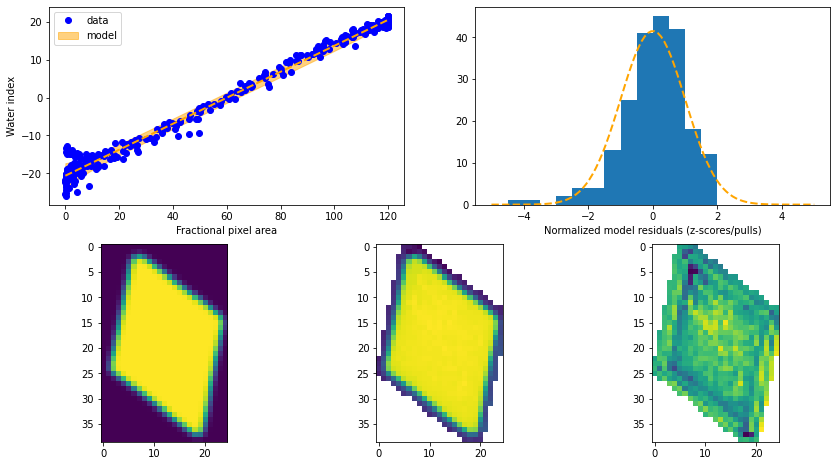

-809.3937426380899


In [75]:
labels = ['slope', 'intercept',
          'sd_full', 'sd_dry', 'sigma', 'xoff', 'yoff', 'sm', 'level']
initial = np.array([0.1, -7, 2, 3, 7, 0.0, 0.0, 0.5, np.mean(b)])
sampler, pos, prob, state = run_mcmc_batch(labels, initial, rs_log_posteriori,
                                           b, a10, w10, 3000, wis_20m=w20,
                                           areas_20m=a20)

### Creating corner plot

(3712, 9)


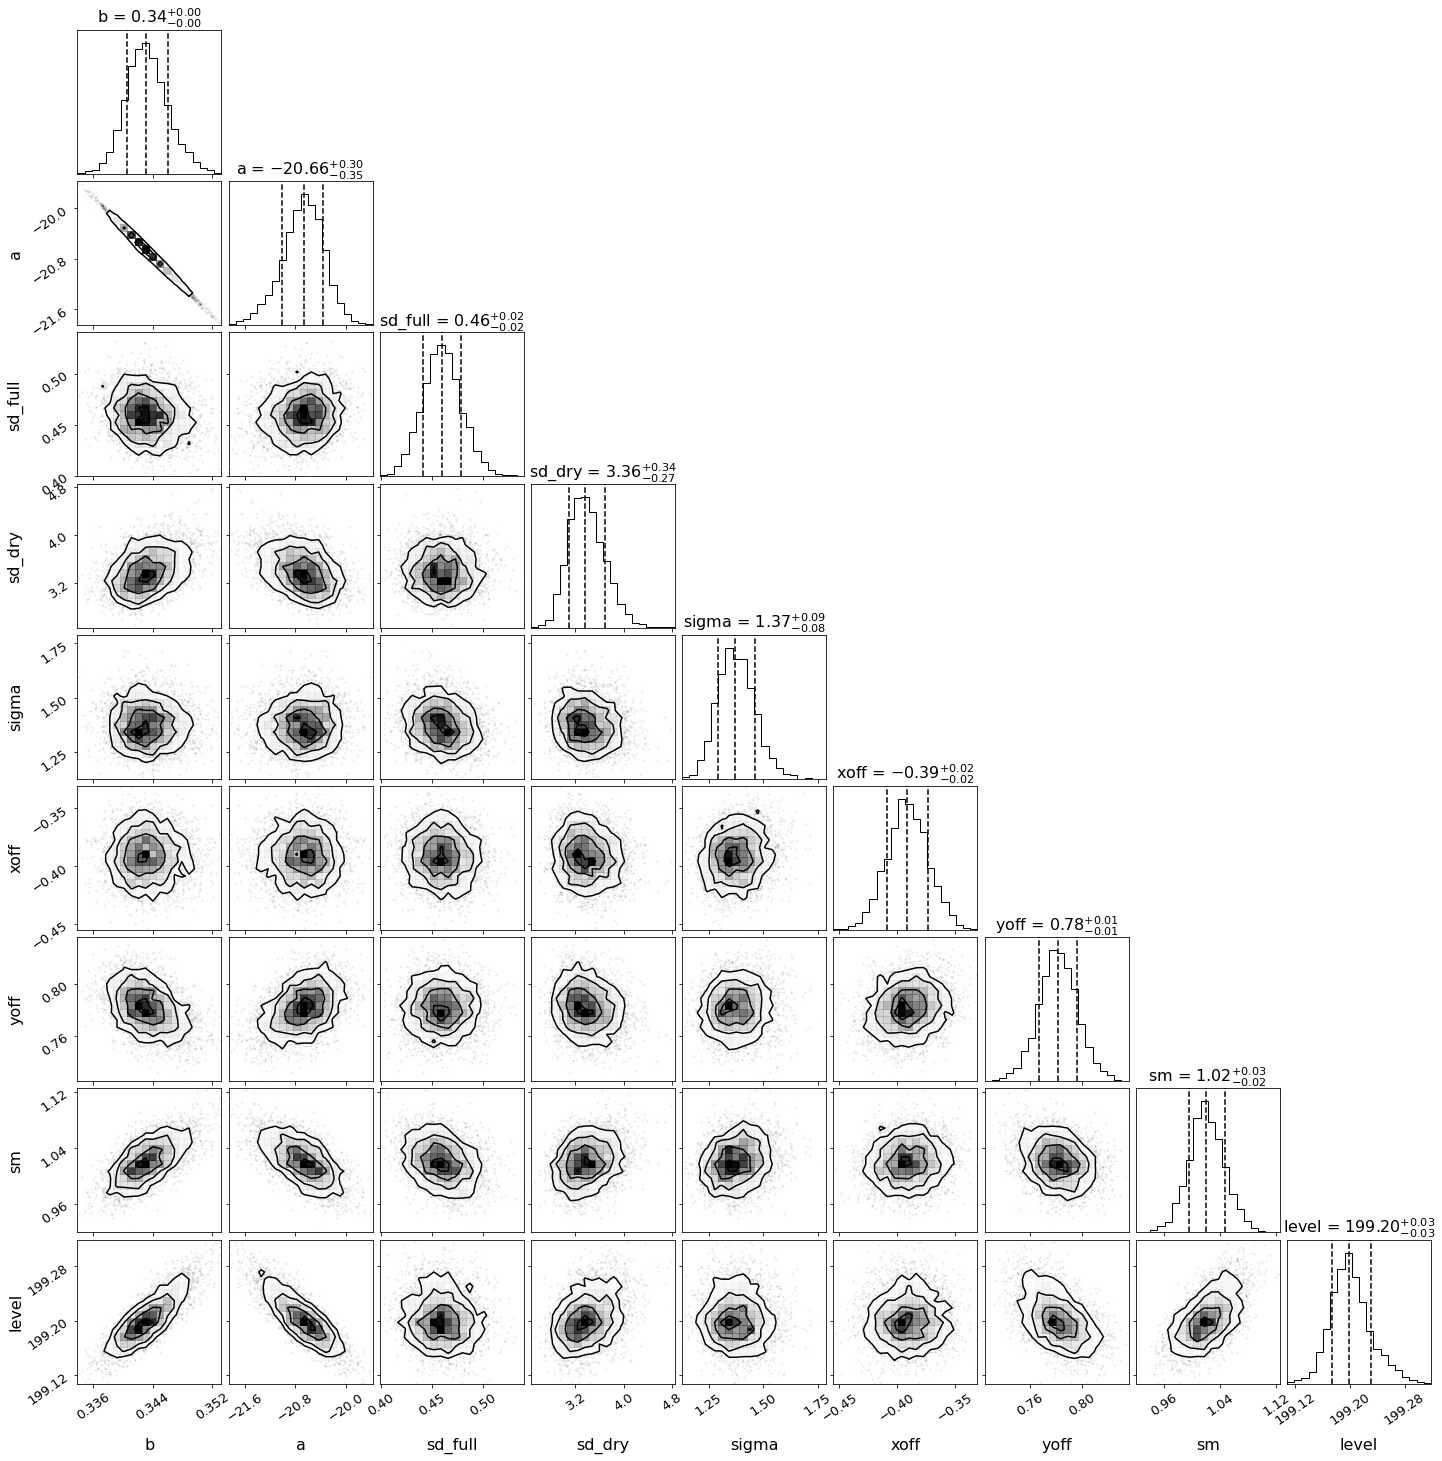

In [76]:
flat_samples = sampler.get_chain(discard=100, thin=100, flat=True)
print(flat_samples.shape)
labels = labels = ['b', 'a', 'sd_full', 'sd_dry',
                   'sigma', 'xoff', 'yoff', 'sm', 'level']
fig = corner.corner(flat_samples,
                    show_titles=True,
                    labels=labels,
                    plot_datapoints=True,
                    quantiles=[0.16, 0.5, 0.84],
                    max_n_ticks=3,
                    label_kwargs=dict(fontsize=16),
                    title_kwargs=dict(fontsize=16),
                    labelpad=0.075)
for i, ax in enumerate(fig.get_axes()):  
    ax.tick_params(axis='y', labelsize=13, rotation=35)
    ax.tick_params(axis='x', labelsize=13, rotation=35)

### Getting MAP probability

In [78]:
samples = sampler.flatchain
theta_bar = samples[np.argmax(sampler.flatlnprobability)]
print(['{}: {}'.format(n, theta_bar[i].round(3)) for i,n in enumerate(labels)])

['b: 0.343', 'a: -20.613', 'sd_full: 0.461', 'sd_dry: 3.308', 'sigma: 1.342', 'xoff: -0.395', 'yoff: 0.779', 'sm: 1.018', 'level: 199.189']
